### Mackenzie Frackleton
### Brenna Manning
## Data Science 2016 Final Project

In [96]:
#IMPORTS
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import numpy as np
import pprint as pp
from IPython.display import display
import scipy.stats as stats

#LOAD DATA
df2013 = pd.read_csv('Kwadela_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadela_winter_2014_cleaned.csv')
df2013.dropna()
df2014.dropna()


,Unnamed: 0,Dusttraks_(mg/m3),PM10_(ug/m3),PM2.5_(ug/m3),SO2_(ppb),CO_(ppm),NO_(ppb),NO2_(ppb),Hour,Minute,...,H06-K-N,H07-K-S,H10-K-N,H11-K-N,H15-K-N,H16-K-N,H17-K-S,H18-K-N,H19-K-W,H22-K-S
56301,56301,0.061,75.314,29.276,19.890,0.136,2.682,11.174,14,21,...,20.6,21.5,24.3,22.4,28.4,27.0,22.9,24.1,24.6,21.0
56302,56302,0.061,151.069,30.839,18.101,0.139,2.682,9.609,14,22,...,20.7,21.5,24.4,22.5,28.4,27.0,22.9,24.1,24.6,21.0
56303,56303,0.061,85.815,87.156,15.420,0.134,2.458,8.939,14,23,...,20.8,21.5,24.4,22.6,28.4,27.0,22.9,24.0,24.7,21.0
56304,56304,0.057,99.225,115.538,14.750,0.159,2.235,9.833,14,24,...,20.8,21.5,24.4,22.6,28.3,27.1,23.0,24.0,24.8,21.0
56305,56305,0.057,106.373,116.876,14.526,0.141,1.341,10.280,14,25,...,20.9,21.5,24.5,22.6,28.2,27.1,23.1,24.0,24.8,21.0
56306,56306,0.057,155.310,115.756,12.738,0.170,1.341,8.268,14,26,...,20.9,21.5,24.5,22.7,28.2,27.1,23.1,24.0,24.9,21.0
56409,56409,0.252,105.934,28.607,16.091,0.206,1.341,14.974,16,9,...,22.1,22.5,22.4,22.1,26.0,26.2,23.2,24.0,27.0,20.7
56410,56410,0.252,105.934,30.618,16.091,0.215,1.341,14.303,16,10,...,22.1,22.5,22.2,22.1,26.0,26.1,23.1,24.0,27.0,20.6
56411,56411,0.252,105.710,29.277,16.091,0.232,1.341,15.197,16,11,...,22.1,22.5,22.1,22.1,25.9,26.1,22.9,24.0,27.0,20.6
56412,56412,0.252,105.710,38.887,17.432,0.264,2.682,16.091,16,12,...,22.2,22.5,21.9,22.0,25.9,26.1,22.8,24.0,27.0,20.6


In [97]:
#SOME HELPER FUNCTIONS
def get_datetime(s):
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def preprocess(df):
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    res['Dusttraks_(mg/m3)']= res['Dusttraks_(mg/m3)']*0.14
    return res


def preprocess14(df):
    res = df.copy()
    res['Dusttraks_(mg/m3)']= res['Dusttraks_(mg/m3)']*0.14
    return res

def daysSinceStart(df):
    #get time since epoch
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
            #do nothing, append the normal day
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        #print'tot days:', total_days, month, day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df


#Daily Average Temp
def compute_avg_temp(df):
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    return df

def tempdifference(df, house):
    df['tempdifference'] = df[house]
    df['tempdifference'] = df[house]-df['Temperature_(degC)']
    return df



In [98]:
#GENERAL FUNCTION FOR DIURNAL DATA

def getmeanfeatureforhour (hourdf, feature):
    res = hourdf[feature].mean()
    return res
def featurediurnaldata(df, feature):
    #feature for example could be a temperature or pollutant concentration
    dfhour0 = df[df['Hour'] == 0]
    feat0 = getmeanfeatureforhour(dfhour0, feature)
    dfhour1 = df[df['Hour'] == 1]
    feat1= getmeanfeatureforhour(dfhour1, feature)
    dfhour2 = df[df['Hour'] == 2]
    feat2 = getmeanfeatureforhour(dfhour2, feature)
    dfhour3 = df[df['Hour'] == 3]
    feat3 = getmeanfeatureforhour(dfhour3, feature)
    dfhour4 = df[df['Hour'] == 4]
    feat4 = getmeanfeatureforhour(dfhour4, feature)
    dfhour5 = df[df['Hour'] == 5]
    feat5 = getmeanfeatureforhour(dfhour5, feature)
    dfhour6 = df[df['Hour'] == 6]
    feat6 = getmeanfeatureforhour(dfhour6, feature)
    dfhour7 = df[df['Hour'] == 7]
    feat7 = getmeanfeatureforhour(dfhour7, feature)
    dfhour8 = df[df['Hour'] == 8]
    feat8 = getmeanfeatureforhour(dfhour8, feature)
    dfhour9 = df[df['Hour'] == 9]
    feat9 = getmeanfeatureforhour(dfhour9, feature)
    dfhour10 = df[df['Hour'] == 10]
    feat10 = getmeanfeatureforhour(dfhour10, feature)
    dfhour11 = df[df['Hour'] == 11]
    feat11 = getmeanfeatureforhour(dfhour11, feature)
    dfhour12 = df[df['Hour'] == 12]
    feat12 = getmeanfeatureforhour(dfhour12, feature)
    dfhour13 = df[df['Hour'] == 13]
    feat13 = getmeanfeatureforhour(dfhour13, feature)
    dfhour14 = df[df['Hour'] == 14]
    feat14 = getmeanfeatureforhour(dfhour14, feature)
    dfhour15 = df[df['Hour'] == 15]
    feat15 = getmeanfeatureforhour(dfhour15, feature)
    dfhour16 = df[df['Hour'] == 16]
    feat16 = getmeanfeatureforhour(dfhour16, feature)
    dfhour17 = df[df['Hour'] == 17]
    feat17 = getmeanfeatureforhour(dfhour17, feature)
    dfhour18 = df[df['Hour'] == 18]
    feat18 = getmeanfeatureforhour(dfhour18, feature)
    dfhour19 = df[df['Hour'] == 19]
    feat19 = getmeanfeatureforhour(dfhour19, feature)
    dfhour20 = df[df['Hour'] == 20]
    feat20 = getmeanfeatureforhour(dfhour20, feature)
    dfhour21 = df[df['Hour'] == 21]
    feat21 = getmeanfeatureforhour(dfhour21, feature)
    dfhour22 = df[df['Hour'] == 22]
    feat22 = getmeanfeatureforhour(dfhour22, feature)
    dfhour23 = df[df['Hour'] == 23]
    feat23 = getmeanfeatureforhour(dfhour23, feature)

    hourlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    featlist = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23]
    return featlist



In [99]:
#PREPROCESS OUR DATAFRAMES

df2013 = preprocess(df2013)
df2013 = daysSinceStart(df2013)
grouped = df2013.groupby('DayCount')
df2013 = grouped.apply(compute_avg_temp)


df2014 = preprocess14(df2014)
df2014 = daysSinceStart(df2014)
grouped = df2014.groupby('DayCount')
df2014 = grouped.apply(compute_avg_temp)

In [100]:
#GET TEMP CUTOFFS

df2013median = df2013['DailyAverageTemp'].median()
df2013abovemed = df2013[df2013['DailyAverageTemp'] > df2013median]
df2013belowmed = df2013[df2013['DailyAverageTemp'] < df2013median]
df2013Q3cutoff = df2013abovemed['DailyAverageTemp'].median()
df2013Q1cutoff = df2013belowmed['DailyAverageTemp'].median()
df2014median = df2014['DailyAverageTemp'].median()
df2014abovemed = df2014[df2014['DailyAverageTemp'] > df2014median]
df2014belowmed = df2014[df2014['DailyAverageTemp'] < df2014median]
df2014Q3cutoff = df2014abovemed['DailyAverageTemp'].median()
df2014Q1cutoff = df2014belowmed['DailyAverageTemp'].median()
print ('2013 cold temp cutoff = ')
print (df2013Q1cutoff)
print('2014 cold temp cutoff = ')
print(df2014Q1cutoff)
print('2014 warm temp cutoff')
print(df2014Q3cutoff)

2013 cold temp cutoff = 
8.6259
2014 cold temp cutoff = 
8.71066111111
2014 warm temp cutoff
14.4178590278


In [101]:


warmcutoff = df2014Q3cutoff #14.4
coldcutoff = df2014Q1cutoff #8.7


df2013cold = df2013[df2013['DailyAverageTemp'] <= coldcutoff]
df2013mid = df2013[df2013['DailyAverageTemp'] > coldcutoff]
df2013mid = df2013mid[df2013mid['DailyAverageTemp'] < warmcutoff]
df2013warm = df2013[df2013['DailyAverageTemp'] >= warmcutoff]
df2013warm.dropna()

df2014cold = df2014[df2014['DailyAverageTemp'] <= coldcutoff]
df2014mid = df2014[df2014['DailyAverageTemp'] > coldcutoff]
df2014mid = df2014mid[df2014mid['DailyAverageTemp'] < warmcutoff]
df2014warm = df2014[df2014['DailyAverageTemp'] >= warmcutoff]


tempdiurnal2013cold = featurediurnaldata(df2013cold, 'DailyAverageTemp')
tempdiurnal2014cold = featurediurnaldata(df2014cold, 'DailyAverageTemp')

In [102]:
print df2013warm

        Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
79920        79920            0.01288        91.360         37.664     12.015   
79921        79921            0.01288        93.156         44.204     11.971   
79922        79922            0.01288        93.156         44.204     11.971   
79923        79923            0.01288        93.156         44.204     11.971   
79924        79924            0.01288        93.156         44.204     11.971   
79925        79925            0.01302        93.156         44.204     11.971   
79926        79926            0.01302        96.696         32.068     11.478   
79927        79927            0.01302        96.696         32.068     11.478   
79928        79928            0.01302        96.696         32.068     11.478   
79929        79929            0.01302        96.696         32.068     11.478   
79930        79930            0.01274        96.696         32.068     11.478   
79931        79931          

## Break dataframes up into time brackets A B C D E

A (midnight-4 am)  B (5-9am), C(10am-2pm) D(3-8pm), E(9-11pm) 

Baseline = A, C, E
Peaks = B (Morning), D (Dinner)

In [103]:
#DATAFRAMES FOR GIVEN TIME RANGES

def abcdeTimeDataframes(df):

    dfA = df[df['Hour'] < 5]

    dfB = df[df['Hour'] > 4]
    dfB = dfB[dfB['Hour'] <= 9]

    dfC = df[df['Hour'] >9]
    dfC = dfC[dfC['Hour'] <= 14]

    dfD = df[df['Hour'] >14]
    dfD = dfD[dfD['Hour'] <= 21]


    dfE = df[df['Hour'] > 21]

    res = [dfA, dfB, dfC, dfD, dfE]
    
    return res


## Analyzing Outdoor Temperature

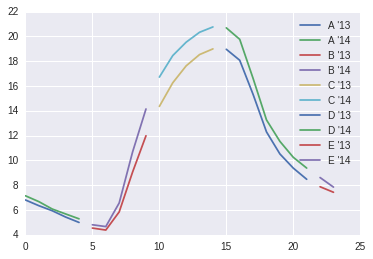

In [104]:
[df2013A, df2013B, df2013C, df2013D, df2013E] = abcdeTimeDataframes(df2013)
[df2014A, df2014B, df2014C, df2014D, df2014E] = abcdeTimeDataframes(df2014)


hourlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

plt.plot(hourlist, featurediurnaldata(df2013A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'Temperature_(degC)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.show()

In [105]:
print('2013:')
print ('A vs B')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2013D['Temperature_(degC)'], df2013E['Temperature_(degC)'])


print('')
print('2014')
print ('A vs B')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2014D['Temperature_(degC)'], df2014E['Temperature_(degC)'])


2013:
A vs B
KruskalResult(statistic=242.36573583120639, pvalue=1.1991674572957914e-54)
A vs C
KruskalResult(statistic=15270.320913598514, pvalue=0.0)
A vs D
KruskalResult(statistic=11094.903190621222, pvalue=0.0)
A vs E
KruskalResult(statistic=620.04055073571988, pvalue=7.3271910777861924e-137)
B vs C
KruskalResult(statistic=12331.220036531144, pvalue=0.0)
B vs D
KruskalResult(statistic=6638.677234465049, pvalue=0.0)
B vs E
KruskalResult(statistic=18.173190667393019, pvalue=2.016982237069756e-05)
C vs D
KruskalResult(statistic=5056.3628836190637, pvalue=0.0)
C vs E
KruskalResult(statistic=9696.6871434795612, pvalue=0.0)
D vs E
KruskalResult(statistic=4977.6297028138952, pvalue=0.0)

2014
A vs B
KruskalResult(statistic=1151.7167179543976, pvalue=1.9001299129319651e-252)
A vs C
KruskalResult(statistic=29255.570493988242, pvalue=0.0)
A vs D
KruskalResult(statistic=20794.793448696597, pvalue=0.0)
A vs E
KruskalResult(statistic=1287.554111955254, pvalue=5.726610957213861e-282)
B vs C
Krusk

In [106]:
print('2013 vs 2014')
print ('A')
print stats.kruskal(df2013A['Temperature_(degC)'], df2014A['Temperature_(degC)'])
print ('B')
print stats.kruskal(df2013B['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('C')
print stats.kruskal(df2013C['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('D')
print stats.kruskal(df2013D['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('E')
print stats.kruskal(df2013E['Temperature_(degC)'], df2014E['Temperature_(degC)'])


2013 vs 2014
A
KruskalResult(statistic=811.26807165503942, pvalue=1.9151409789060449e-178)
B
KruskalResult(statistic=423.56903055839859, pvalue=4.0795502265722341e-94)
C
KruskalResult(statistic=3.1139733181302316, pvalue=0.077623383568087775)
D
KruskalResult(statistic=464.0996145871365, pvalue=6.1624418293675769e-103)
E
KruskalResult(statistic=227.01060383265539, pvalue=2.674842547934165e-51)


### This shows the dirunal outdoor temperature is different for all of the data frames, even when dividing up into segments by time.  Let's try splitting into dataframes by temperature brackets as well as times.

In [107]:
[df2013coldA, df2013coldB, df2013coldC, df2013coldD, df2013coldE] = abcdeTimeDataframes(df2013cold)
[df2014coldA, df2014coldB, df2014coldC, df2014coldD, df2014coldE] = abcdeTimeDataframes(df2014cold)
[df2013midA, df2013midB, df2013midC, df2013midD, df2013midE] = abcdeTimeDataframes(df2013mid)
[df2014midA, df2014midB, df2014midC, df2014midD, df2014midE] = abcdeTimeDataframes(df2014mid)
[df2013warmA, df2013warmB, df2013warmC, df2013warmD, df2013warmE] = abcdeTimeDataframes(df2013warm)
[df2014warmA, df2014warmB, df2014warmC, df2014warmD, df2014warmE] = abcdeTimeDataframes(df2014warm)

print df2013warmA


        Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
79920        79920            0.01288        91.360         37.664     12.015   
79921        79921            0.01288        93.156         44.204     11.971   
79922        79922            0.01288        93.156         44.204     11.971   
79923        79923            0.01288        93.156         44.204     11.971   
79924        79924            0.01288        93.156         44.204     11.971   
79925        79925            0.01302        93.156         44.204     11.971   
79926        79926            0.01302        96.696         32.068     11.478   
79927        79927            0.01302        96.696         32.068     11.478   
79928        79928            0.01302        96.696         32.068     11.478   
79929        79929            0.01302        96.696         32.068     11.478   
79930        79930            0.01274        96.696         32.068     11.478   
79931        79931          

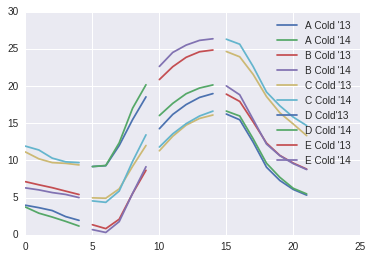

In [108]:

plt.plot(hourlist, featurediurnaldata(df2013coldA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014coldA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013coldB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014coldB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013coldC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014coldC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013coldD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014coldD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013midA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014midA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013midB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014midB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013midC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014midC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013midD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014midD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmD, 'Temperature_(degC)'))
plt.legend(["A Cold '13", "A Cold '14", "B Cold '13", "B Cold '14", "C Cold '13", "C Cold '14", "D Cold'13", "D Cold '14", "E Cold '13", "E Cold '14" ])
plt.show()

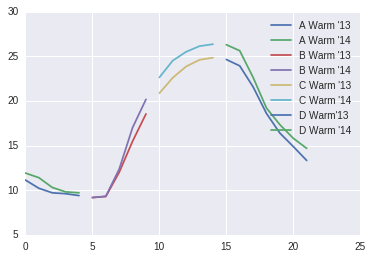

In [109]:
plt.plot(hourlist, featurediurnaldata(df2013warmA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmA, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmB, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmC, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warmD, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warmD, 'Temperature_(degC)'))
plt.legend(["A Warm '13", "A Warm '14", "B Warm '13", "B Warm '14", "C Warm '13", "C Warm '14", "D Warm'13", "D Warm '14", "E Warm '13", "E Warm '14" ])
plt.show()

In [110]:
print('2013 vs 2014')
print ('A Cold')
print stats.kruskal(df2013coldA['Temperature_(degC)'], df2014coldA['Temperature_(degC)'])
print ('A Mid')
print stats.kruskal(df2013midA['Temperature_(degC)'], df2014midA['Temperature_(degC)'])
print ('A Warm')
print stats.kruskal(df2013warmA['Temperature_(degC)'], df2014warmA['Temperature_(degC)'])

print ('B Cold')
print stats.kruskal(df2013coldB['Temperature_(degC)'], df2014coldB['Temperature_(degC)'])
print ('B Mid')
print stats.kruskal(df2013midB['Temperature_(degC)'], df2014midB['Temperature_(degC)'])
print ('B Warm')
print stats.kruskal(df2013warmB['Temperature_(degC)'], df2014warmB['Temperature_(degC)'])

print ('C')
print ('C Cold')
print stats.kruskal(df2013coldC['Temperature_(degC)'], df2014coldC['Temperature_(degC)'])
print ('C Mid')
print stats.kruskal(df2013midC['Temperature_(degC)'], df2014midC['Temperature_(degC)'])
print ('C Warm')
print stats.kruskal(df2013warmC['Temperature_(degC)'], df2014warmC['Temperature_(degC)'])


print ('D')
print ('D Cold')
print stats.kruskal(df2013coldD['Temperature_(degC)'], df2014coldD['Temperature_(degC)'])
print ('D Mid')
print stats.kruskal(df2013midD['Temperature_(degC)'], df2014midD['Temperature_(degC)'])
print ('D Warm')
print stats.kruskal(df2013warmD['Temperature_(degC)'], df2014warmD['Temperature_(degC)'])

print ('E')
print ('E Cold')
print stats.kruskal(df2013coldE['Temperature_(degC)'], df2014coldE['Temperature_(degC)'])
print ('E Mid')
print stats.kruskal(df2013midE['Temperature_(degC)'], df2014midE['Temperature_(degC)'])
print ('E Warm')
print stats.kruskal(df2013warmE['Temperature_(degC)'], df2014warmE['Temperature_(degC)'])



2013 vs 2014
A Cold
KruskalResult(statistic=193.63760786629365, pvalue=5.1092639360882022e-44)
A Mid
KruskalResult(statistic=245.06744873899899, pvalue=3.0890325721446019e-55)
A Warm
KruskalResult(statistic=129.34743587171479, pvalue=5.6928179051451407e-30)
B Cold
KruskalResult(statistic=20.723085174303012, pvalue=5.307229908759832e-06)
B Mid
KruskalResult(statistic=0.50790731628884789, pvalue=0.47604616877102779)
B Warm
KruskalResult(statistic=31.660418301492491, pvalue=1.8362685552610915e-08)
C
C Cold
KruskalResult(statistic=56.457184984485977, pvalue=5.743546812541639e-14)
C Mid
KruskalResult(statistic=650.2353571077283, pvalue=1.9857549372252993e-143)
C Warm
KruskalResult(statistic=442.85001775056139, pvalue=2.5952369333988059e-98)
D
D Cold
KruskalResult(statistic=25.501637591293683, pvalue=4.4200759388136878e-07)
D Mid
KruskalResult(statistic=0.12838469117985141, pvalue=0.72011276055671392)
D Warm
KruskalResult(statistic=92.205530546618007, pvalue=7.8126128435368822e-22)
E
E Cold


### Analyzing PM4

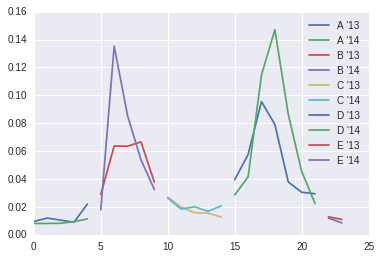

In [111]:
[df2013A, df2013B, df2013C, df2013D, df2013E] = abcdeTimeDataframes(df2013)
[df2014A, df2014B, df2014C, df2014D, df2014E] = abcdeTimeDataframes(df2014)


hourlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

plt.plot(hourlist, featurediurnaldata(df2013A, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'Dusttraks_(mg/m3)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.show()

### Use Kruskal to show that they are different in different times of the day

In [112]:
print('2013:')
print ('A vs B')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013B['Dusttraks_(mg/m3)'])
print ('A vs C')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013C['Dusttraks_(mg/m3)'])
print ('A vs D')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('A vs E')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('B vs C')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013C['Dusttraks_(mg/m3)'])
print ('B vs D')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('B vs E')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('C vs D')
print stats.kruskal(df2013C['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('C vs E')
print stats.kruskal(df2013C['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('D vs E')
print stats.kruskal(df2013D['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])


print('')
print('2014')
print ('A vs B')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014B['Dusttraks_(mg/m3)'])
print ('A vs C')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014C['Dusttraks_(mg/m3)'])
print ('A vs D')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('A vs E')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('B vs C')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014C['Dusttraks_(mg/m3)'])
print ('B vs D')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('B vs E')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('C vs D')
print stats.kruskal(df2014C['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('C vs E')
print stats.kruskal(df2014C['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('D vs E')
print stats.kruskal(df2014D['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])


2013:
A vs B
KruskalResult(statistic=6165.755889329721, pvalue=0.0)
A vs C
KruskalResult(statistic=700.99256086639411, pvalue=1.8191373429576186e-154)
A vs D
KruskalResult(statistic=8176.3927827925781, pvalue=0.0)
A vs E
KruskalResult(statistic=7.8753521743147124, pvalue=0.0050113111117083735)
B vs C
KruskalResult(statistic=3182.0066700719522, pvalue=0.0)
B vs D
KruskalResult(statistic=133.5158426394961, pvalue=6.972408450483177e-31)
B vs E
KruskalResult(statistic=3289.1794281321304, pvalue=0.0)
C vs D
KruskalResult(statistic=4598.2245221676358, pvalue=0.0)
C vs E
KruskalResult(statistic=345.41514809597368, pvalue=4.2225484441438309e-77)
D vs E
KruskalResult(statistic=4017.4352906759432, pvalue=0.0)

2014
A vs B
KruskalResult(statistic=231.35309665529081, pvalue=3.0217494427064326e-52)
A vs C
KruskalResult(statistic=930.72374149200994, pvalue=2.0557568155379535e-204)
A vs D
KruskalResult(statistic=68.229218526800693, pvalue=1.4555294875051922e-16)
A vs E
KruskalResult(statistic=1174.23

#### Comaring the times of day to each other the kruskal tests show that they are never the same.

In [113]:
print('2013 vs 2014')
print ('A')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2014A['Dusttraks_(mg/m3)'])
print ('B')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2014B['Dusttraks_(mg/m3)'])
print ('C')
print stats.kruskal(df2013C['Dusttraks_(mg/m3)'], df2014C['Dusttraks_(mg/m3)'])
print ('D')
print stats.kruskal(df2013D['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('E')
print stats.kruskal(df2013E['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])


2013 vs 2014
A
KruskalResult(statistic=7234.9295502919822, pvalue=0.0)
B
KruskalResult(statistic=8979.5822610693158, pvalue=0.0)
C
KruskalResult(statistic=4320.483216358848, pvalue=0.0)
D
KruskalResult(statistic=10445.309817860072, pvalue=0.0)
E
KruskalResult(statistic=2976.4688428954537, pvalue=0.0)


#### As shown above^  Even for the same time brackets of the day, PM4 concentrations are statistically not the same.

### Let's try breaking it up by temperature bracket as well as time of day

In [114]:
[df2013coldA, df2013coldB, df2013coldC, df2013coldD, df2013coldE] = abcdeTimeDataframes(df2013cold)
[df2014coldA, df2014coldB, df2014coldC, df2014coldD, df2014coldE] = abcdeTimeDataframes(df2014cold)
[df2013midA, df2013midB, df2013midC, df2013midD, df2013midE] = abcdeTimeDataframes(df2013mid)
[df2014midA, df2014midB, df2014midC, df2014midD, df2014midE] = abcdeTimeDataframes(df2014mid)
[df2013warmA, df2013warmB, df2013warmC, df2013warmD, df2013warm] = abcdeTimeDataframes(df2013warm)
[df2014warmA, df2014warmB, df2014warmC, df2014warmD, df2014warmE] = abcdeTimeDataframes(df2014warm)


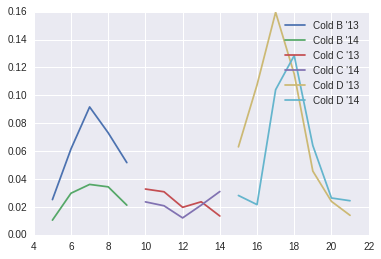

In [115]:
hourlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

plt.plot(hourlist, featurediurnaldata(df2013coldB, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014coldB, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013coldC, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014coldC, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013coldD, 'Dusttraks_(mg/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014coldD, 'Dusttraks_(mg/m3)'))
plt.legend(["Cold B '13", "Cold B '14", "Cold C '13", "Cold C '14", "Cold D '13", "Cold D '14" ])
plt.show()

In [116]:
print('2013:')
print ('A vs B')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013B['Dusttraks_(mg/m3)'])
print ('A vs C')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013C['Dusttraks_(mg/m3)'])
print ('A vs D')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('A vs E')
print stats.kruskal(df2013A['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('B vs C')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013C['Dusttraks_(mg/m3)'])
print ('B vs D')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('B vs E')
print stats.kruskal(df2013B['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('C vs D')
print stats.kruskal(df2013C['Dusttraks_(mg/m3)'], df2013D['Dusttraks_(mg/m3)'])
print ('C vs E')
print stats.kruskal(df2013C['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])
print ('D vs E')
print stats.kruskal(df2013D['Dusttraks_(mg/m3)'], df2013E['Dusttraks_(mg/m3)'])


print('')
print('2014')
print ('A vs B')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014B['Dusttraks_(mg/m3)'])
print ('A vs C')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014C['Dusttraks_(mg/m3)'])
print ('A vs D')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('A vs E')
print stats.kruskal(df2014A['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('B vs C')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014C['Dusttraks_(mg/m3)'])
print ('B vs D')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('B vs E')
print stats.kruskal(df2014B['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('C vs D')
print stats.kruskal(df2014C['Dusttraks_(mg/m3)'], df2014D['Dusttraks_(mg/m3)'])
print ('C vs E')
print stats.kruskal(df2014C['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])
print ('D vs E')
print stats.kruskal(df2014D['Dusttraks_(mg/m3)'], df2014E['Dusttraks_(mg/m3)'])


2013:
A vs B
KruskalResult(statistic=6165.755889329721, pvalue=0.0)
A vs C
KruskalResult(statistic=700.99256086639411, pvalue=1.8191373429576186e-154)
A vs D
KruskalResult(statistic=8176.3927827925781, pvalue=0.0)
A vs E
KruskalResult(statistic=7.8753521743147124, pvalue=0.0050113111117083735)
B vs C
KruskalResult(statistic=3182.0066700719522, pvalue=0.0)
B vs D
KruskalResult(statistic=133.5158426394961, pvalue=6.972408450483177e-31)
B vs E
KruskalResult(statistic=3289.1794281321304, pvalue=0.0)
C vs D
KruskalResult(statistic=4598.2245221676358, pvalue=0.0)
C vs E
KruskalResult(statistic=345.41514809597368, pvalue=4.2225484441438309e-77)
D vs E
KruskalResult(statistic=4017.4352906759432, pvalue=0.0)

2014
A vs B
KruskalResult(statistic=231.35309665529081, pvalue=3.0217494427064326e-52)
A vs C
KruskalResult(statistic=930.72374149200994, pvalue=2.0557568155379535e-204)
A vs D
KruskalResult(statistic=68.229218526800693, pvalue=1.4555294875051922e-16)
A vs E
KruskalResult(statistic=1174.23